# BITCOIN TRADING AGENT - SWING TRADING STRATEGY

## CONTEXT

The client is a fintech company focused on crypto trading and wants to build a smart bitcoin trading system designed to operate with minimal human supervision and continuously adapt to changing market conditions. 

The agent must dynamically manage budget allocation, shift between strategies, and make autonomous trading decisions while running 24/7. The BTC Agent takes into account different trading strategies and make decisions accordingly. Following strategies are to be tested:

- **Dollar Cost Averaging (DCA)** - For the *Value Investing* Strategy - Invest fix amounts at regular intervals 
- **Average True Range (ATR) Stop-Loss** - For the *Day Trading* Strategy - Trade at high frequency - Stop Loss when BTC drops below a certain threshold
- **LSTM Neural Network** - For the *Swing Trading* - Trade over time to maximize the profit at a BUY-SELL action 

In this notebook, the LSTM for the Swing Trading is documented. The model will be deployed at the real-time for live predictions in the dash app. 

## DATA DESCRIPTION 

The BTC data is fetched live in OHLCV (Open-High-Low-Close-Volume) from two public sources:
- Binance
- Yahoo Finance

Binance is the primary data source and if Binance does fetch live data due to any restriction, the agent fetches from Yahoo Finance. 

Each row in a BTC data is called a "Candle". So, we say the agent fetches live BTC Candles. 

### COLUMNS

The BTC Candles has five standard features:
- **Open** - opening price of the candle at the start of the given day
- **High** - highest price of the candle throughout the given day
- **Low** - lowest price of the candle throughout the given day
- **Close** - closing price of the candle at the end of the given day 
- **Volume** - total volumne or amount of BTC that was traded for the given day

Furthermore, five techincal indicators are added as calculated features:
- **SMA** - *Simple Moving Average* - Moving average based on the closing price over a rolling window of 14 days 
- **ATR** - *Average True Range* - average price range of a candle over 14 days - *True Range = max(high-low, abs(high-prev_close), abs(low-prev_close))*
- **RSI** - *Relative Strength Index* - measure market momentum by comparing the speed and magnitude of recent price changes over 14 days
- **EMA** - *Exponential Moving Average* - a technical indicator that assigns greater weight to more recent price and help identify entry-exit points in a trade
- **MACD** - *Moving average convergence/divergence (MACD)* - momentum indicator that shows the relationship between two moving averages of a candle's price

## OBJECTIVES

- Find the features or indicators that have the strongest effect on the BTC price of a candle.
- Perform time-series analysis on the dataset using an LSTM Neural Network.
- Evaluate the performance of the model and how does it aid in building strategies for Swing Trading.   


## METHODLOGY 

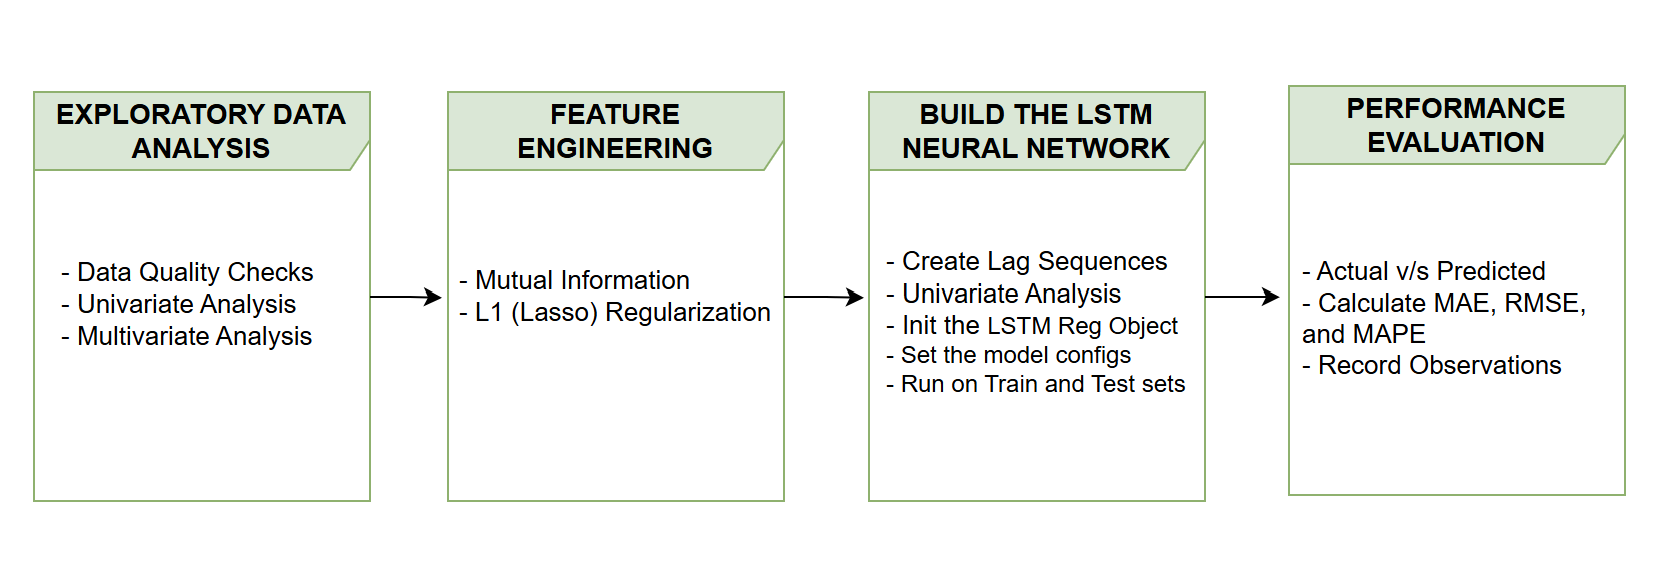

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from data.data_fetcher import get_ohlcv
from indicators.technicals import compute_rsi, compute_ema, compute_macd, compute_atr, compute_sma
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("installed all dependencies...")

installed all dependencies...


## EXPLORATORY DATA ANALYSIS 

### DATA QUALITY CHECKS 

In [2]:
# Get live BTC data on a 4h time stamp 
df = get_ohlcv("BTCUSDT", "4h", 2000)

# Add calculated features
df = compute_atr(df, period=14)
df = compute_rsi(df, period=14)
df = compute_sma(df, period=50)
df = compute_ema(df, period=50)
df = compute_macd(df)

# drop NULL records 
df = df.dropna().reset_index(drop=True)

df.tail()

Fetching BTCUSDT from Binance...
 Binance fetch failed: HTTPSConnectionPool(host='api.binance.com', port=443): Max retries exceeded with url: /api/v3/klines?symbol=BTCUSDT&interval=4h&limit=2000 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002B5C8A9DF50>: Failed to resolve 'api.binance.com' ([Errno 11001] getaddrinfo failed)"))
Fetching from Yahoo Finance instead...


Price,timestamp,open,high,low,close,volume,prev_close,tr1,tr2,tr3,true_range,ATR,RSI,SMA_50,EMA_50,EMA_fast,EMA_slow,MACD,Signal
305,2025-09-12 00:00:00+00:00,115509.007812,116313.515625,115094.921875,115220.484375,6253064192,115516.468750,1218.593750,797.046875,421.546875,1218.593750,853.836496,79.473035,111908.052187,112331.663957,114056.136725,113115.245341,940.891384,737.969445
306,2025-09-12 04:00:00+00:00,115212.585938,115676.625000,115119.179688,115135.992188,2593009664,115220.484375,557.445312,456.140625,101.304688,557.445312,852.505580,77.887482,111976.551094,112441.637613,114222.268335,113264.930293,957.338042,781.843165
307,2025-09-12 08:00:00+00:00,115137.429688,115243.726562,114886.812500,114938.054688,1851052032,115135.992188,356.914062,107.734375,249.179688,356.914062,835.257812,75.987669,112050.960156,112539.536322,114332.389312,113388.865433,943.523879,814.179308
308,2025-09-12 12:00:00+00:00,114950.421875,115482.460938,114804.148438,115153.882812,257040384,114938.054688,678.312500,544.406250,133.906250,678.312500,803.480469,72.676184,112143.082969,112642.059714,114458.772928,113519.607461,939.165466,839.176539
309,2025-09-12 16:00:00+00:00,115143.406250,116581.882812,115111.781250,116570.164062,23994417152,115153.882812,1470.101562,1428.000000,42.101562,1470.101562,863.073661,80.702932,112257.738125,112796.103021,114783.602333,113745.574617,1038.027716,878.946775


In [3]:
df.shape

(310, 19)

In [4]:
df.dtypes

Price
timestamp     datetime64[ns, UTC]
open                      float64
high                      float64
low                       float64
close                     float64
volume                      int64
prev_close                float64
tr1                       float64
tr2                       float64
tr3                       float64
true_range                float64
ATR                       float64
RSI                       float64
SMA_50                    float64
EMA_50                    float64
EMA_fast                  float64
EMA_slow                  float64
MACD                      float64
Signal                    float64
dtype: object

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.isna().sum()

Price
timestamp     0
open          0
high          0
low           0
close         0
volume        0
prev_close    0
tr1           0
tr2           0
tr3           0
true_range    0
ATR           0
RSI           0
SMA_50        0
EMA_50        0
EMA_fast      0
EMA_slow      0
MACD          0
Signal        0
dtype: int64

#### OBSERVATIONS

- The dataset has 311 rows X 19 columns - each rows is a BTC candle across OHCLV + technical indicators/calculated features.
- There are no duplicate candles or candles with NULL for any of the features.
- All the features are continuous in nature, only the reference column is a timestamp which is datetime.

### UNIVARIATE ANALYSIS

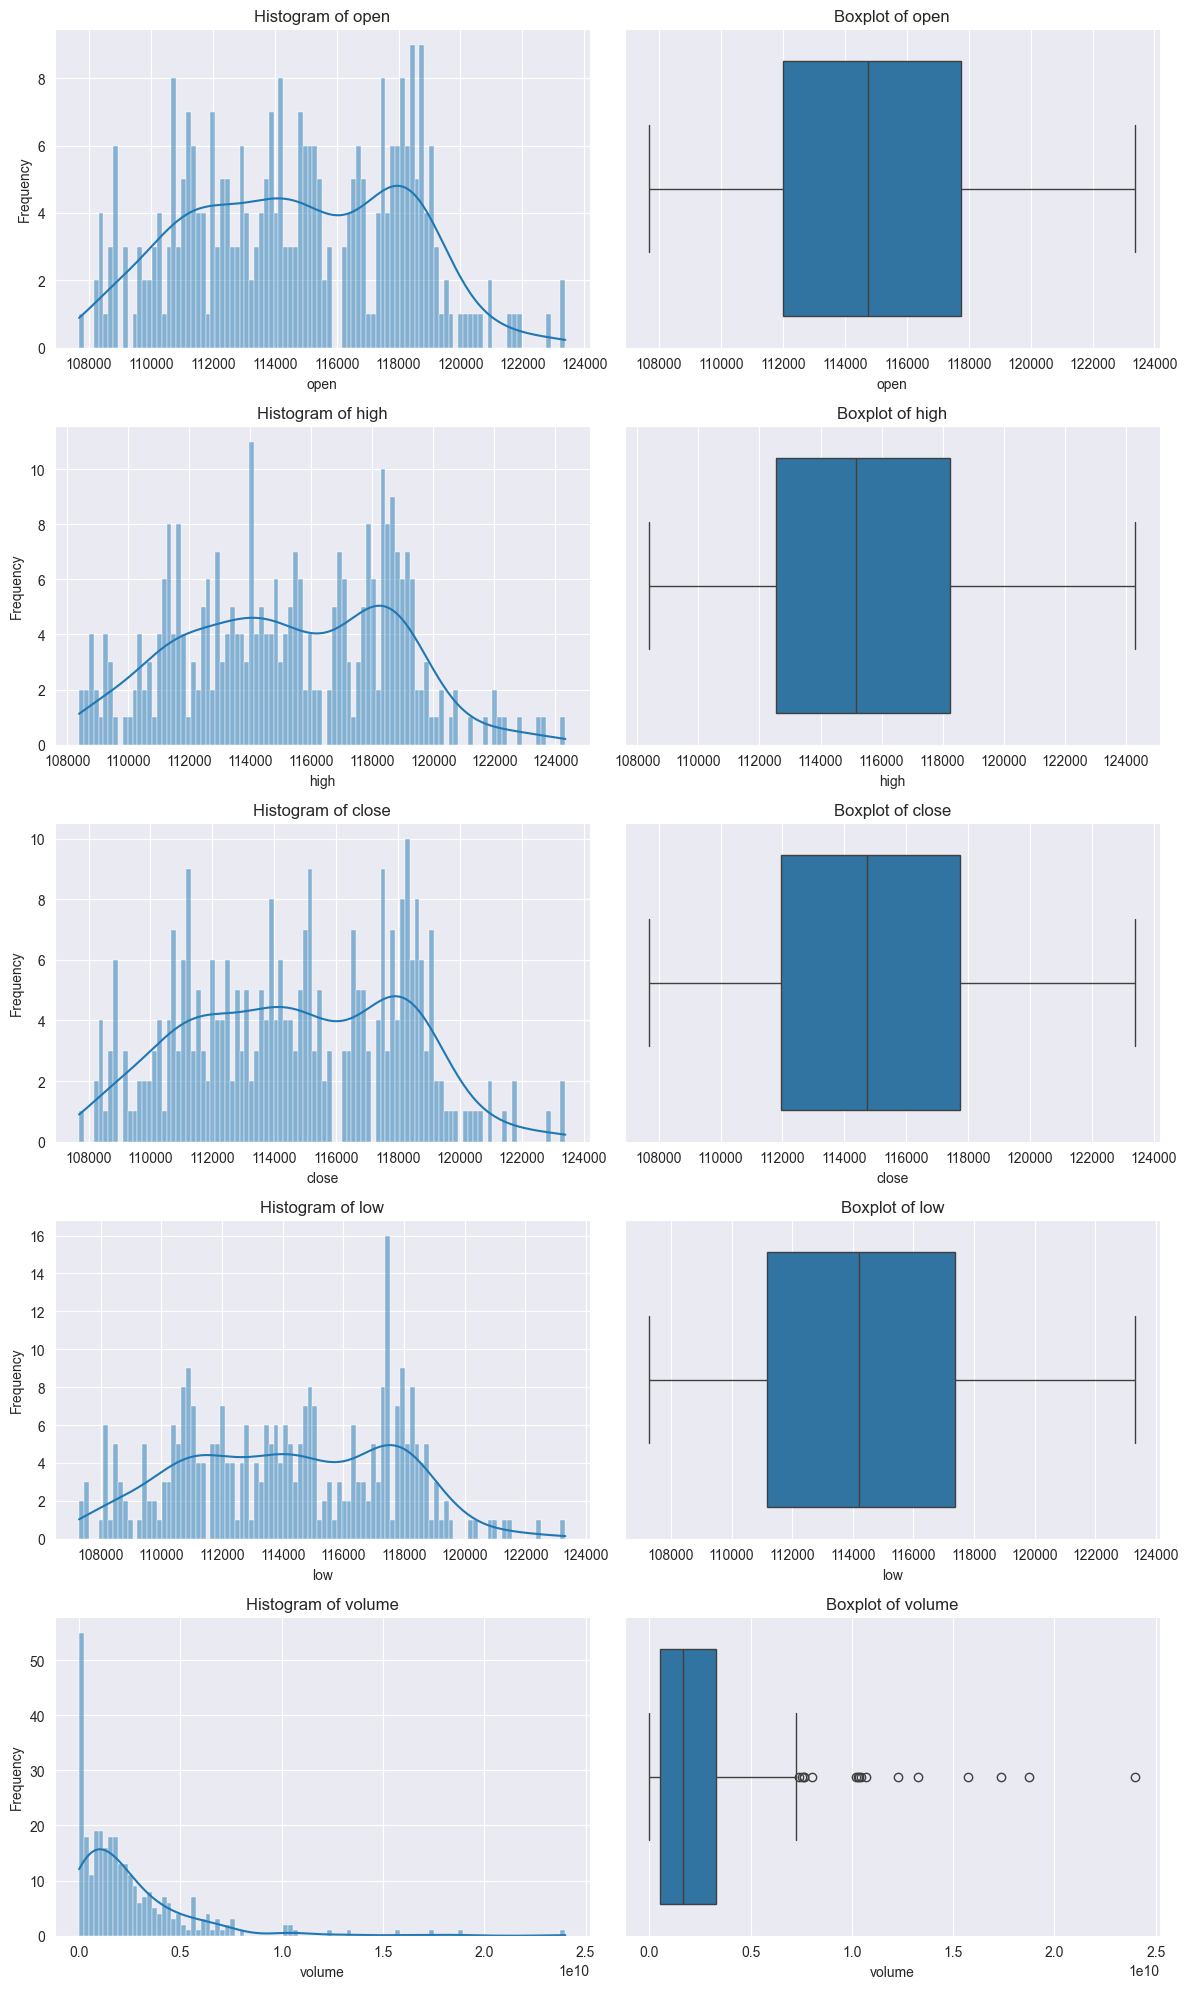

In [7]:
"""
    plot_hist_box() : function to generate the histogram and box plot for the given feature(s)
    @params : data - the pandas dataframe comprising the dataset, continuous_cols[] - an array holding the continuous features column names
    @return: None
"""
def plot_hist_box(data, continuous_cols):

    n = len(continuous_cols)
    plt.figure(figsize=(12, 4 * n))

    for i, col in enumerate(continuous_cols):
        # Histogram
        plt.subplot(n, 2, 2*i + 1)
        sns.histplot(data[col], bins=100, kde=True)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # Boxplot
        plt.subplot(n, 2, 2*i + 2)
        sns.boxplot(x=data[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

plot_hist_box(df, ['open', 'high', 'close', 'low', 'volume'])

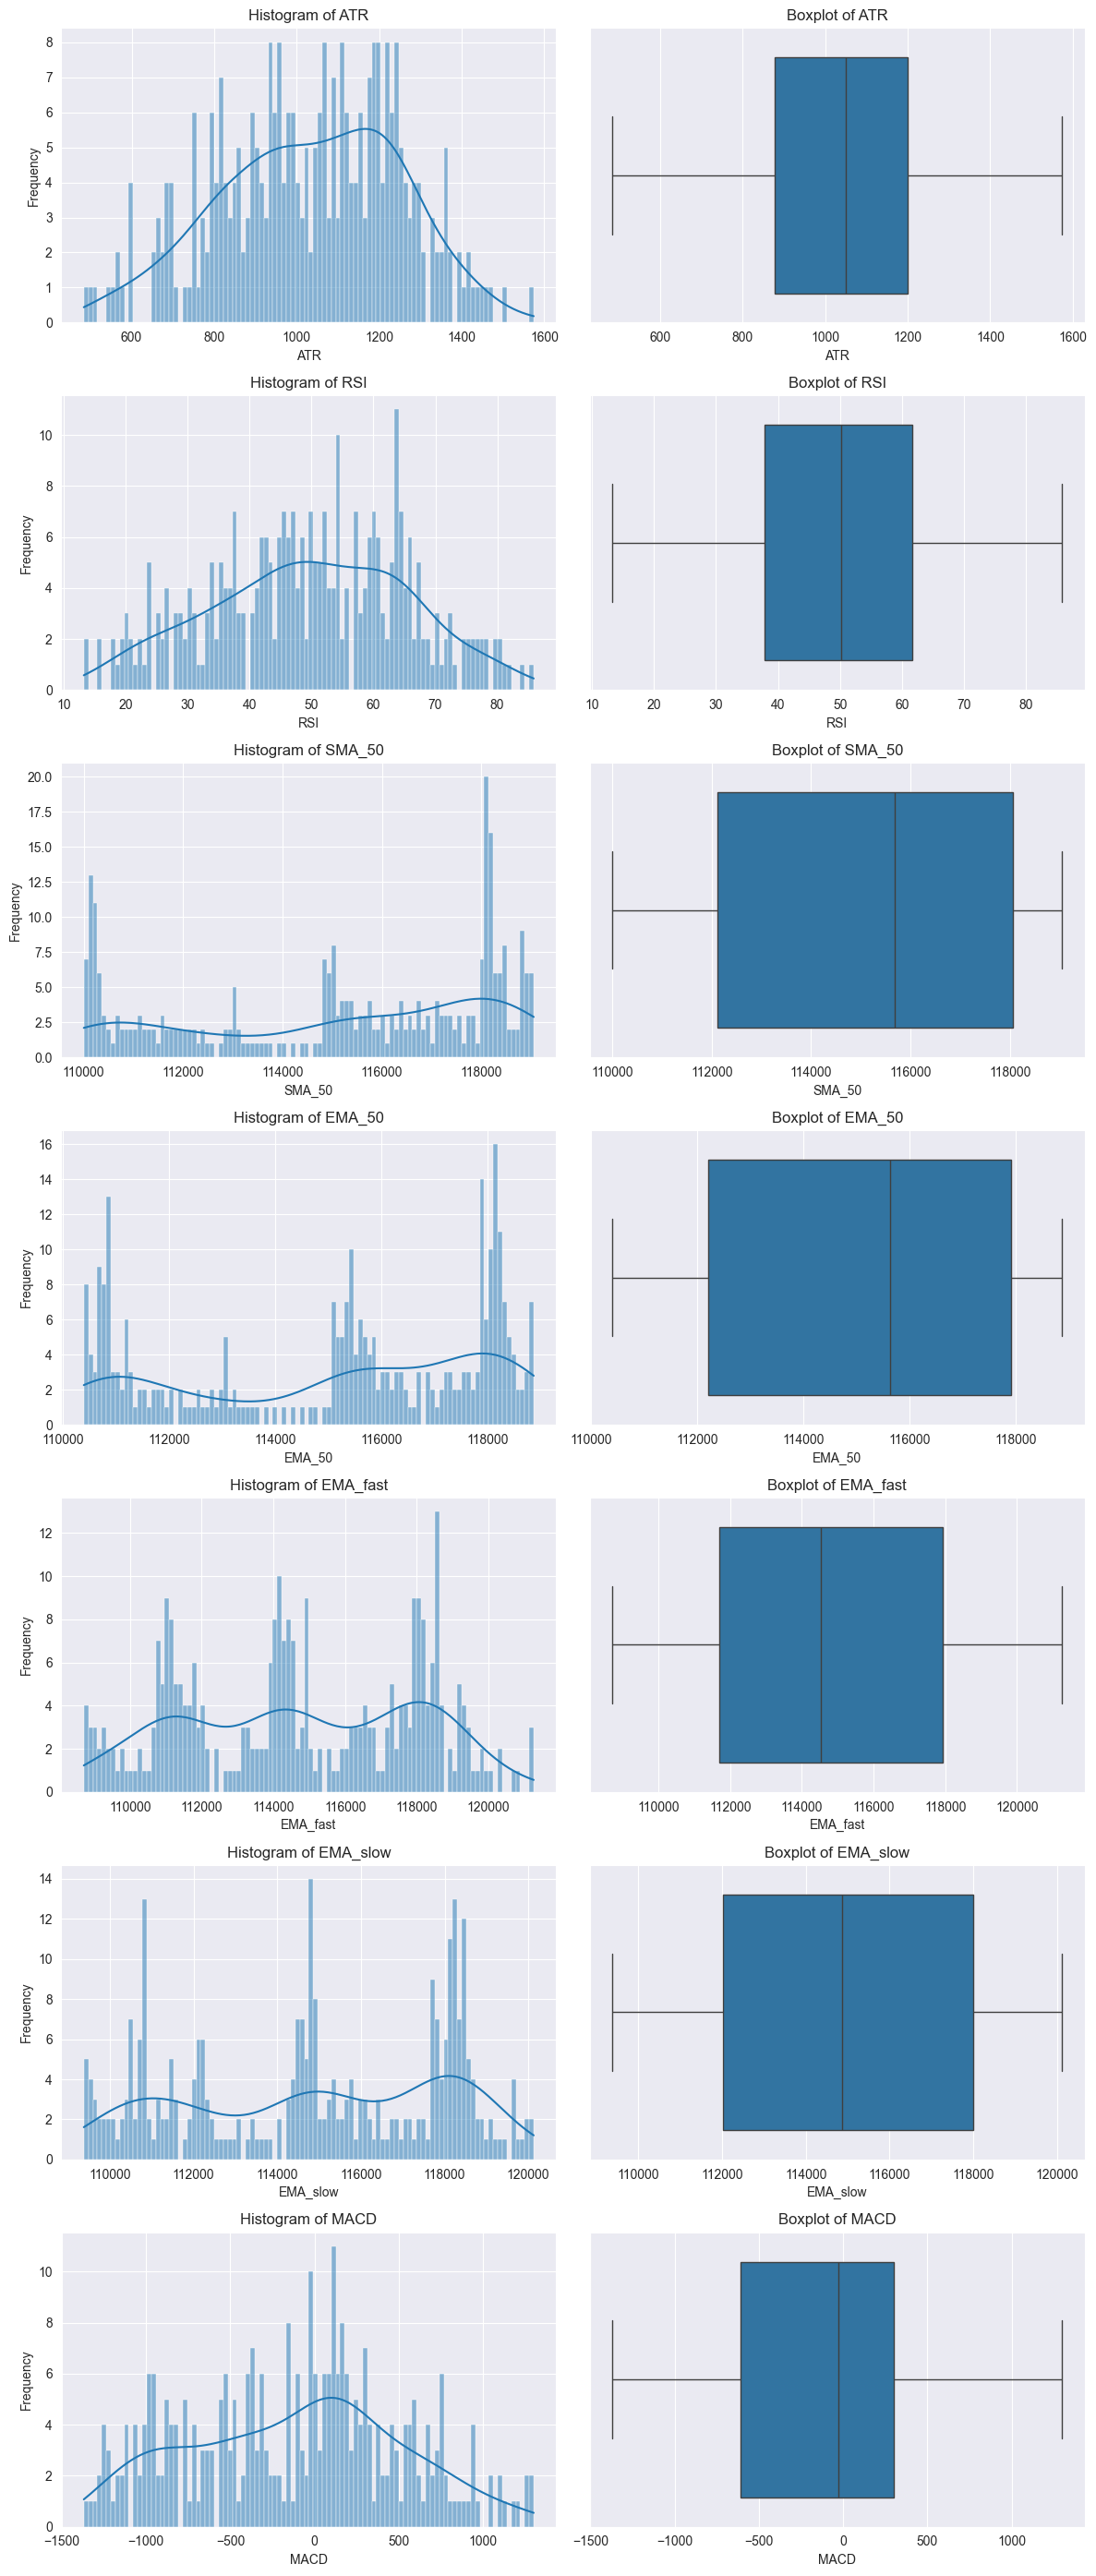

In [8]:
plot_hist_box(df, ['ATR', 'RSI', 'SMA_50', 'EMA_50', 'EMA_fast', 'EMA_slow', 'MACD'])

#### OBSERVATIONS
- Open, High, Low and Close are almost identical in distribution, with Volume being the only strongly skewed variable, towards the right.
- Scaling is mandatory before feeding to the LSTM.
- For time-sensitive features (SMA/EMA), LSTM can benefit from including them as they capture longer-term memory in price trends.
- No outliers detected in either technical indicators or standard features - except for the Volume.

### MULTIVARIATE ANALYSIS

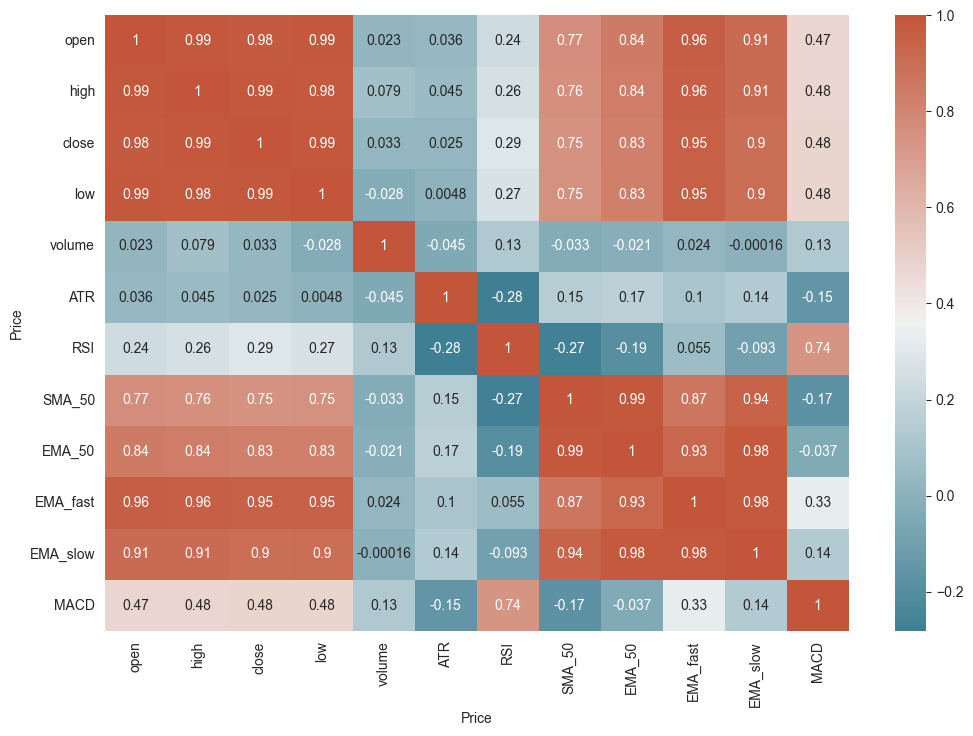

In [9]:
corr1 = df[['open', 'high', 'close', 'low', 'volume', 'ATR',
            'RSI', 'SMA_50', 'EMA_50', 'EMA_fast', 'EMA_slow', 'MACD']].corr()

plt.figure(figsize=(12, 8))  # increase width and height as needed
sns.heatmap(
    corr1,
    xticklabels=corr1.columns,
    yticklabels=corr1.columns,
    annot=True,
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
)
plt.show()

#### OBSERVATIONS
- Open, High, and Low are extremely correlated to each other and to Close - including them would be redundant and cause multicollinearity.
- SMA_50, EMA_50, EMA_fast, and EMA_slow are highly correlated with each other - select one or two depending upon further analysis.
-  Volume is weakly correlated to the target Close as well as to other features - recommended to exclude.
-  RSI and MACD Provide Distinct Signals - meaning they capture signficant information and are also moderately correlated to the target.
-  ATR has comparatively low correlation with the price variables but captures orthogonal information about volatility.

## FEATURE ENGINEERING

### MULTUAL INFORMATION 

- Based on the Multivariate Analysis, check how much information do the orthogonal features contribute towards the target = Close.  


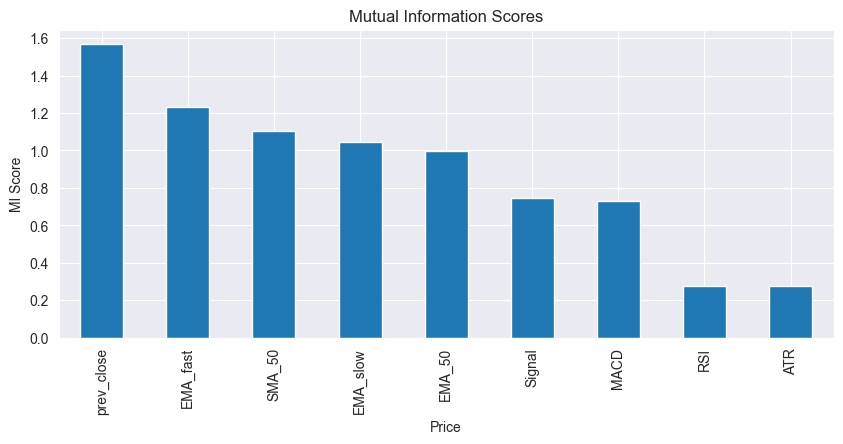

In [17]:
from sklearn.feature_selection import mutual_info_regression

# Candidate features
X = df[["prev_close", "SMA_50", "EMA_50", "Signal", "EMA_fast", "EMA_slow", "RSI", "MACD", "ATR"]]
y = df["close"]

# Compute MI scores
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# --- Bar Plot ---
mi_scores.plot(kind="bar", figsize=(10,4), title="Mutual Information Scores")
plt.ylabel("MI Score")
plt.show()

### L1 (LASSO REGULARIZATION)

- Use L1 Regularization as an optimizer on the Mutual Information - to further drill down and minimize overfitting in the feature set. 

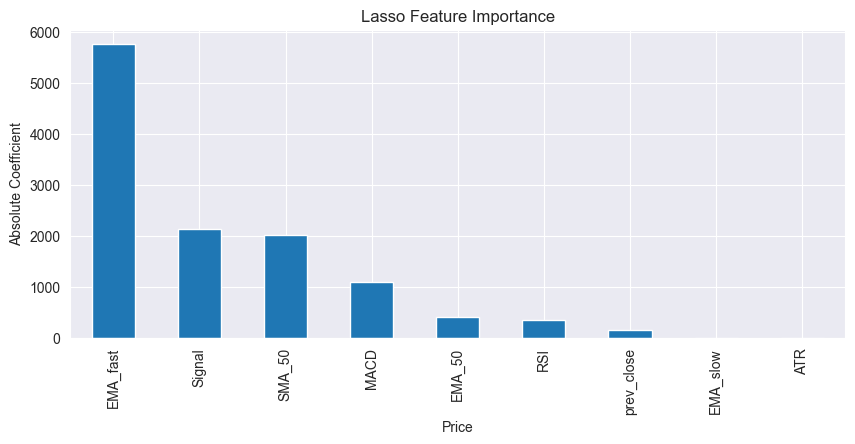

In [18]:
from sklearn.linear_model import LassoCV

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso with cross-validation
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Get feature importance (absolute coefficients)
lasso_importance = pd.Series(np.abs(lasso.coef_), index=X.columns).sort_values(ascending=False)

# --- Bar Plot ---
lasso_importance.plot(kind="bar", figsize=(10,4), title="Lasso Feature Importance")
plt.ylabel("Absolute Coefficient")
plt.show()

#### OBSERVATIONS

Based on the Mutual Information:
- Top drivers: prev_close, EMA_fast, SMA_50, EMA_slow, EMA_50.
- Moderate: Signal, MACD.
- Weak: RSI, ATR.
 MI confirms that trend-following features (MAs/EMAs) carry the strongest nonlinear dependency with close.


Based L1 (Lasso) Regularization:
- Strongest weights: EMA_fast, Signal, SMA_50, MACD.
- Moderate: EMA_50, RSI, prev_close.
- Zeroed out: EMA_slow, ATR.
- Lasso is a harsher metric and an optimizer over the Mutual Information - it prunes redundancy and volatility measures first.

Finalized Feature Set - [ **prev_close**, **EMA_fast**, **Signal**, **MACD**, **SMA_50** ]

## BUILD THE LSTM NEURAL NETWORK

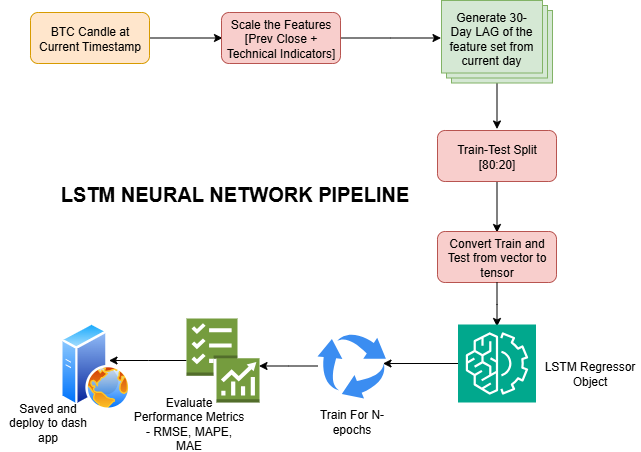

In [ ]:
SEQ_LEN = 30

features = ['prev_close', 'EMA_fast', 'Signal', 'MACD', 'SMA_50']

#features = ["close", "RSI", "SMA_50", "EMA_50", "MACD", "Signal", "ATR"]

X1 = df[features].values
y1 = df["close"].values  # target is next close

# Scale features and target separately
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X1)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y1.reshape(-1,1)).flatten()

# Make sequences
def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])  # next value
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# Train/test split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).view(-1,1)


In [ ]:
# Init the LSTM Regressor Object
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # last timestep
        out = self.fc(out)
        return out

In [ ]:
# Define the model and the configs
model = LSTMRegressor(input_dim=X_train.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 5, Loss: 0.209274
Epoch 10, Loss: 0.184914
Epoch 15, Loss: 0.194871
Epoch 20, Loss: 0.118435
Epoch 25, Loss: 0.181073
Epoch 30, Loss: 0.141388


## PERFORMANCE EVALUATION

RMSE: 2233.84
MAE: 2011.75
MAPE: 1.79%


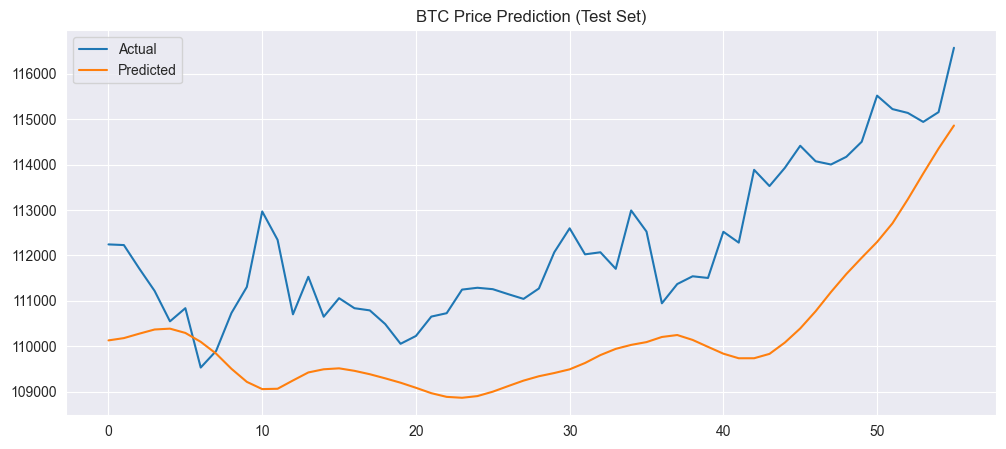

In [29]:
from sklearn.metrics import mean_absolute_percentage_error

model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_t).numpy().flatten()

# Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler_y.inverse_transform(y_test_t.numpy()).flatten()

# rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# print(f"RMSE: {rmse:.2f}")

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")

plt.figure(figsize=(12,5))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("BTC Price Prediction (Test Set)")
plt.show()


#### OBSERVATIONS

**Performance Metrics:**
- RMSE = 2233.84
- MAE = 2011.75
- MAPE = 1.79%

Generally speaking, a MAPE under 5% in financial time-series forecasting is quite decent, given how noisy BTC data tends to be.

**Insights on the Actual V/s Predicted BTC Prices:**
- Predicted values are comparatively smoother and lag the actual values - so, it means towards taking lower risks in swing trading.
- Hence, the model is capturing the trend direction, but underestimates volatility and sharp jumps.
- This is expected for LSTM regression - it minimizes average error, so tends to smoothen instead of chasing spikes.


In [30]:
# Save the model 
import joblib

torch.save(model.state_dict(), "models/lstm_regressor_v3.pt")

joblib.dump(scaler_X, "models/lstm_X_scaler_v3.pkl")
joblib.dump(scaler_y, "models/lstm_y_scaler_v3.pkl")

['models/lstm_y_scaler_v3.pkl']